In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from os import path
from scipy.interpolate import interp1d
root = "/project/wyin/jlee/ml-project"
util_loc = path.join(root, "utils")
data_loc = path.join(root, "inverse-shifted/data")
model_loc = path.join(root, "")
sys.path.append(util_loc)
from sklearn.preprocessing import StandardScaler
import torch
from utilities import UnscaledData, get_model, LitNeuralNet

In [2]:
k_data_loc = path.join(root, "data-collection/full-dataset/data")
k_dat = np.loadtxt(path.join(k_data_loc, 'param_-0.16_0.30_0.600', 'disp_10-01.dat'))
e_m = np.round(k_dat[32, 1], 2)
print(e_m)
dos = np.loadtxt(path.join(k_data_loc, 'param_-0.16_0.30_0.600', 'dos.dat'))

-2.71


In [3]:
def interp_dos(w, dos, new_w):
    ret_dos = np.zeros(len(new_w))
    f = interp1d(w, dos, kind = "cubic")
    
    int_inds = np.where((new_w > w[0]) & (new_w < w[-1])) #only interpolate indices inside original w range, otherwise value is 0
    ret_dos[int_inds] = f(new_w[int_inds])
    
    return ret_dos

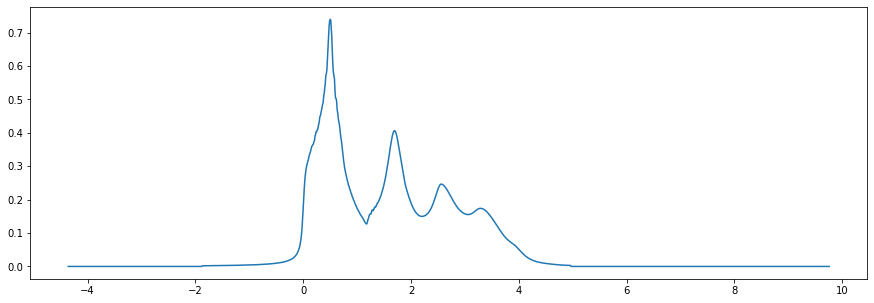

In [4]:
#Use t = 0.57 to scale data
exp_dos = np.zeros((1413, 2)) #Our pretend experimental dos
exp_dos[:,0] = np.arange(-4.36, 9.77, 0.01)

scaled_grid = 0.57 * (dos[:,0] - e_m)
scaled_vals = dos[:,1] / 0.57
exp_dos[:,1] = interp_dos(scaled_grid, scaled_vals, exp_dos[:,0])

plt.figure(figsize=(15, 5))
plt.plot(exp_dos[:,0], exp_dos[:,1])

In [92]:
#After this point, all we know is exp_dos!

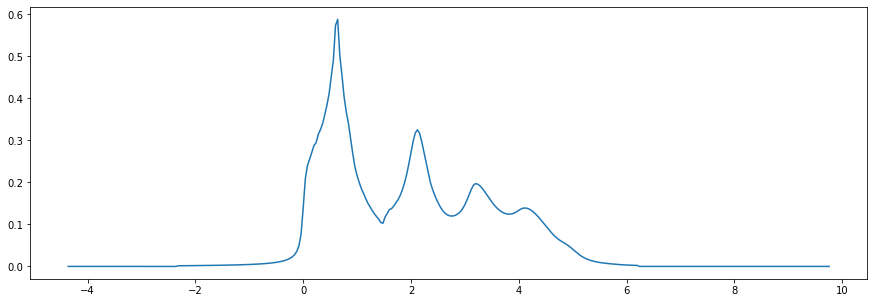

In [5]:
#Dos in units of t, for a guess of t, in the window of -4.36 to 9.76
def rescale(t):
    rescaled_grid = exp_dos[:,0] / t
    rescaled_vals = exp_dos[:,1] * t
    
    dos_vec = interp_dos(rescaled_grid, rescaled_vals, np.linspace(-4.36, 9.76, 354))
    return dos_vec

plt.figure(figsize = (15, 5))
plt.plot(np.linspace(-4.36, 9.76, 354), rescale(0.8))

In [6]:
model_loc = path.join(root, 
                      "inverse-shifted/neural-nets/hyperparameters/logs/arch-search-15-min-2", 
                      "[354, 256, 128, 64, 32, 3],0.001,128,0.5")
model = get_model(model_loc)

data = UnscaledData(data_loc, X_name = "dos", y_name = "params")
scaler = StandardScaler()
scaler.fit(data.train_X)

def predict(dos):
    dos_arr = dos.reshape(1, -1)
    scaled_dos = scaler.transform(dos_arr)
    dos_tensor = torch.from_numpy(scaled_dos).float()
    return model(dos_tensor).detach().numpy()[0]

In [7]:
mse_arr = []
params_arr = []
for t in np.arange(0.01, 4.0, 0.01):
    params = predict(rescale(t))
    mse = np.mean((params - np.array([-0.16, 0.30, 0.600])) ** 2)
    
    params_arr.append(params)
    mse_arr.append(mse)
    
    
params_arr = np.array(params_arr)
mse_arr = np.array(mse_arr)

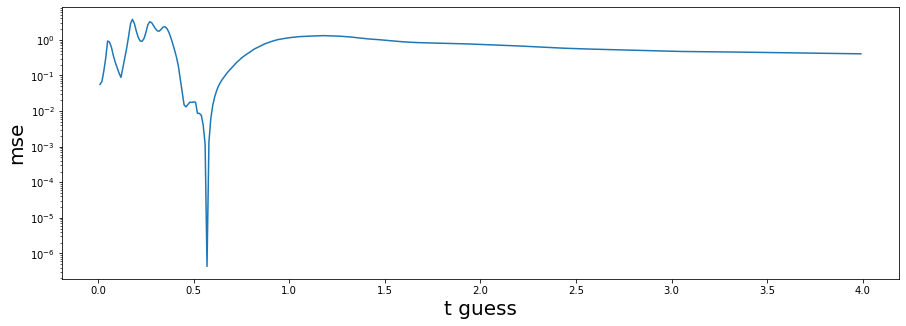

In [8]:
plt.figure(figsize = (15, 5))
plt.yscale("log")
plt.ylabel("mse", size = 20)
plt.xlabel("t guess", size = 20)
plt.plot(np.arange(0.01, 4.0, 0.01), mse_arr)

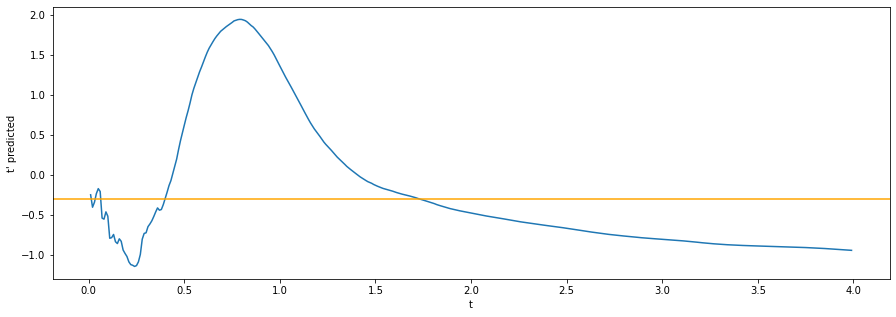

In [179]:
plt.figure(figsize = (15, 5))
plt.ylabel("t' predicted")
plt.xlabel("t")
plt.plot(np.arange(0.01, 4.0, 0.01), params_arr[:,0])
plt.axhline(y = -0.3, color = "orange")

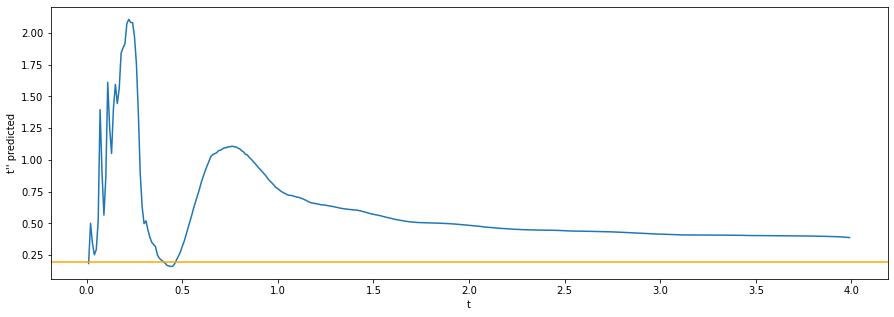

In [180]:
plt.figure(figsize = (15, 5))
plt.ylabel("t'' predicted")
plt.xlabel("t")
plt.plot(np.arange(0.01, 4.0, 0.01), params_arr[:,1])
plt.axhline(y = 0.2, color = "orange")

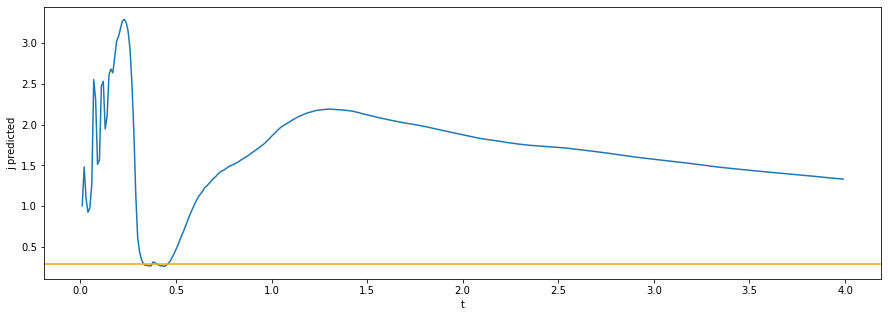

In [183]:
plt.figure(figsize = (15, 5))
plt.ylabel("j predicted")
plt.xlabel("t")
plt.plot(np.arange(0.01, 4.0, 0.01), params_arr[:,2])
plt.axhline(y = 0.296, color = "orange")